In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

Files already downloaded and verified


In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


# Display Random Image

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

#def imshow(img):
#    img = img / 2 + 0.5     # unnormalize
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#    plt.axis('off')
#    plt.show()

def imshow(img, upscale_factor=4):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg.shape)

    plt.figure(figsize=(upscale_factor, upscale_factor))
    if npimg.shape[0] == 3:
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    else:
        plt.imshow(npimg, cmap='gray')
        
    #print(np.shape(np.transpose(npimg, (1, 2, 0))))
    plt.axis('off')
    plt.show()

In [7]:
def display_image(dataset,idx=-1):
    # Get a random index if idx is not specified
    if idx == -1:
        idx = torch.randint(0, len(dataset), (1,)).item()
    #print(idx)
    
    # Get the image and label at the random index
    img, label = dataset[idx]
    #print(dataset[idx])
    
    # Display the image
    imshow(img,1)
    
    # Print the label
    print(f"Label: {classes[label]}")

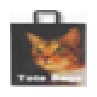

Label: cat


In [8]:
display_image(trainset,3000)

In [9]:

def convert_to_grayscale(dataset):
    new_dataset = []
    for img, label in dataset:
        weights = torch.tensor([0.2989, 0.5870, 0.1140]).view( 3, 1, 1)
        # Convert to grayscale
        gray_img  = torch.sum(img * weights, dim=0)

        new_val = [gray_img,label]
        new_dataset.append(new_val)
    return new_dataset

In [10]:
trainset_grayscale = convert_to_grayscale(trainset)
testset_grayscale = convert_to_grayscale(testset)

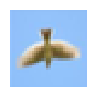

Label: bird


In [11]:
idx = 9876
display_image(trainset,idx)

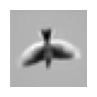

Label: bird


In [12]:
display_image(trainset_grayscale,idx)

# Build a PyTorch Network to train

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self,normalization='none'):
        super(UNet, self).__init__()
        
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        self.dec3 = DoubleConv(512 , 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

        self.normalization = normalization

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        #print(f"After enc1: {e1.shape}")
        
        e2 = self.enc2(self.pool(e1))
        #print(f"After enc2: {e2.shape}")
        
        e3 = self.enc3(self.pool(e2))
        #print(f"After enc3: {e3.shape}")
        
        e4 = self.enc4(self.pool(e3))
        #print(f"After enc4: {e4.shape}")
        
        # Decoder
        d3 = self.upconv3(e4)
        #print(f"After upconv3: {d3.shape}")
        d3 = torch.cat([d3, e3], dim=1)
        #print(f"After concat with e3: {d3.shape}")
        d3 = self.dec3(d3)
        #print(f"After dec3: {d3.shape}")
        
        d2 = self.upconv2(d3)
        #print(f"After upconv2: {d2.shape}")
        d2 = torch.cat([d2, e2], dim=1)
        #print(f"After concat with e2: {d2.shape}")
        d2 = self.dec2(d2)
        #print(f"After dec2: {d2.shape}")
        
        d1 = self.upconv1(d2)
        #print(f"After upconv1: {d1.shape}")
        d1 = torch.cat([d1, e1], dim=1)
        #print(f"After concat with e1: {d1.shape}")
        d1 = self.dec1(d1)
        #print(f"After dec1: {d1.shape}")
        
        out = self.final_conv(d1)
        #print(f"Final output shape: {out.shape}")
        #apply normalization
        if self.normalization == 'softmax':
            out = self.channel_softmax_norm(out)
        elif self.normalization == 'sigmoid':
            out = torch.sigmoid(out)
        elif self.normalization == 'minmax':
            out = self.channel_minmax_norm(out)
        
        return out
       
    
def channel_softmax_norm(x):
    b, c, h, w = x.shape
    # Reshape to (batch, channels, height * width)
    x_reshaped = x.view(b, c, -1)
    # Apply softmax independently for each channel
    x_softmax = F.softmax(x_reshaped, dim=2)
    # Reshape back to original shape
    return x_softmax.view(b, c, h, w)

def channel_minmax_norm(x):
    b, c, h, w = x.shape
    # Reshape to (batch, channels, height * width)
    x_reshaped = x.view(b, c, -1)
    x_min = x_reshaped.min(dim=2, keepdim=True)[0]
    x_max = x_reshaped.max(dim=2, keepdim=True)[0]
    # Normalize
    x_normalized = (x_reshaped - x_min) / (x_max - x_min + 1e-8)
    # Reshape back to original shape
    return x_normalized.view(b, c, h, w)
    

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

In [16]:
torch.rand(1,32,32).shape

torch.Size([1, 32, 32])

In [17]:
out = model(torch.rand(5,1,32,32).to(device))
out.shape

torch.Size([5, 3, 32, 32])

# Define Data loader and training


In [4]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm, trange


In [19]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        #self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_image = self.input_data[idx]
        target_image = self.target_data[idx]
        
        #if self.transform:
        #    input_image = self.transform(input_image)
        #    target_image = self.transform(target_image)
        
        return input_image, target_image

# Hyperparameters
batch_size = 50
learning_rate = 0.001
weight_decay = 0.01  # AdamW weight decay parameter
num_epochs = 100


In [5]:
norm = 'none'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(normalization=norm).to(device)


In [28]:
#extract only images from the grayscale dataset
input_data = [img.unsqueeze(0) for img, _ in trainset_grayscale]
#if norm == 'sigmoid': 
if norm == 'sigmoid':
    target_data = [torch.sigmoid(img) for img, _ in trainset]
if norm == 'softmax':
    target_data = [ channel_softmax_norm(img.unsqueeze(0)).squeeze(0) for img, _ in trainset]
else:
    target_data = [img for img, _ in trainset]

In [29]:
dataset = CustomDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,pin_memory=True)

In [30]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [31]:
#Number of parameters that are trainable

sum(p.numel() for p in model.parameters() if p.requires_grad)

7701955

In [6]:
from torchsummary import summary
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             576
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,728
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

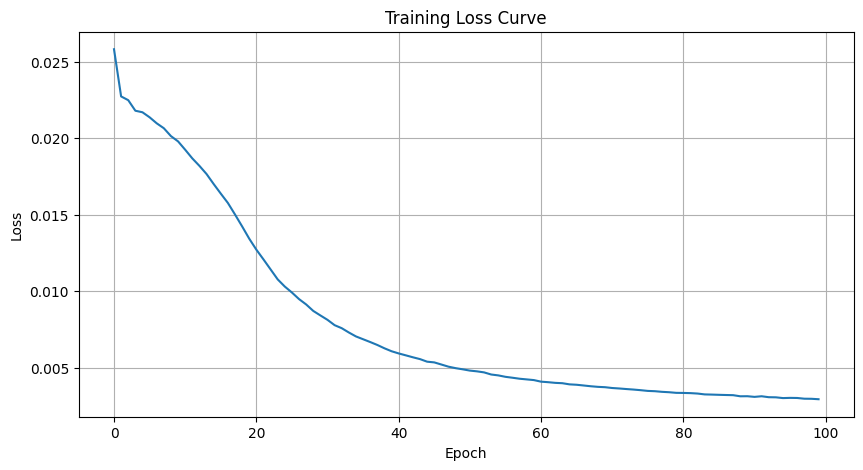

Training completed!


In [33]:

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Function to plot the loss curve
def plot_loss_curve(losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Initialize list to store losses
losses = []

for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    batch_loss = 0.0
    
    # tqdm wrapper for dataloader
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", position =0, leave=False)
    
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item() * inputs.size(0)
        
        # Update progress bar
        #pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
    
    epoch_loss = batch_loss / len(dataset)
    losses.append(epoch_loss)
    
    # Print epoch loss
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Plot loss curve every 5 epochs or at the last epoch
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        plot_loss_curve(losses)

# Save the trained model
torch.save(model.state_dict(), "unet_model_b_"+str(batch_size)+"_ep_"+str(num_epochs)+"_norm_"+norm+".pth")

# Final loss curve plot
plot_loss_curve(losses)

print("Training completed!")

In [41]:
#load model from disk
norm_list = ('none','sigmoid','softmax','minmax')
norm = norm_list[1]
print(f"Using model with "{norm}"  normalization")
model_infer = UNet(normalzation = norm).to(device)
model_infer.load_state_dict(torch.load("unet_model_b_50_ep_100_"+norm+".pth", map_location=torch.device(device)))
#run inference
def run_inference(model, input_tensor):
    with torch.no_grad():  # No need to track gradients during inference
        output = model(input_tensor)
    return output

/tmp/ipykernel_1103634/3570613712.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_infer.load_state_dict(torch.load("unet_model_b_50_ep_100.pth", map_location=torch

# Run inference on Random train sample

In [51]:
#randomly select an image from the trainset_grayscale
import random
idx = random.randint(0, len(trainset_grayscale))
print(idx)
input_img, _ = trainset_grayscale[idx]
input_tensor = input_img.reshape(1,1,32,32).to(device)
test_output = run_inference(model_infer, input_tensor)

38376


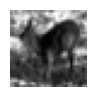

Label: deer


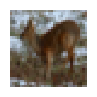

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: deer


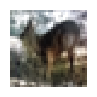

In [52]:
display_image(trainset_grayscale,idx)
display_image(trainset,idx)
imshow(test_output.squeeze(0).to('cpu'),1)

# Run inference on Random Test sample

In [63]:
#randomly select an image from the testset_grayscale
import random
idx = random.randint(0, len(testset_grayscale))
print(idx)
input_img, _ = testset_grayscale[idx]
input_tensor = input_img.reshape(1,1,32,32).to(device)
test_output = run_inference(model_infer, input_tensor)

5599


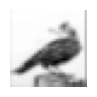

Label: bird


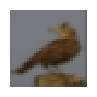

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bird


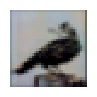

In [64]:
display_image(testset_grayscale,idx)
display_image(testset,idx)
imshow(test_output.squeeze(0).to('cpu'),1)